In [42]:
import requests
import pandas as pd
import numpy as np 
%matplotlib inline 
import matplotlib.pyplot as plt

def load_data_OpenDataTO(package_id):
    """
    Load a dataset from the Toronto Open Data API.

    Parameters:
    - package_id (str): The ID of the package containing the dataset in a dict {}.

    Returns:
    - pd.DataFrame or None: A DataFrame containing the dataset if successfully loaded, 
                            or None if an error occurred.
    """
    # Define the base URL for the Toronto Open Data API
    base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

    # Define the URL to access the metadata of a package
    url = base_url + "/api/3/action/package_show"

    # Set the parameters to retrieve information about the desired package
    params = {"id": package_id}
         
    # Send a GET request to retrieve metadata about the package
    response = requests.get(url, params=params)

    # Check if the GET request was successful
    if response.status_code == 200:
        # Parse the JSON response
        package_info = response.json()
        
        # Extract information about the resources in the package
        resources = package_info['result']['resources']
        
        # Look for a JSON resource and load its data using CKAN API
        for resource in resources:
            if resource['format'].lower() == 'json':
                url = base_url + "/api/3/action/datastore_search"
                params = {"id": resource["id"]}
                resource_search_data = requests.get(url, params=params).json()["result"]
                df = pd.DataFrame(resource_search_data["records"])
                print("Toronto Open DataFrame created successfully using CKAN API parameters.")
                return df
        else:
            print("No JSON resource found in the package.")
            return None
    else:
        print("Failed to retrieve metadata from the API.")
        return None

# Load the Annual Police Report data into the DataFrame
    
package_id = "police-annual-statistical-report-arrested-and-charged-persons"

annual_police_report = load_data_OpenDataTO(package_id)

annual_police_report.head()

Toronto Open DataFrame created successfully using CKAN API parameters.


,_id,ARREST_YEAR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,SEX,AGE_COHORT,AGE_GROUP,CATEGORY,SUBTYPE,ARREST_COUNT
0,1,2019,D14,83,Dufferin Grove (83),Female,25 to 34,Adult,Other Criminal Code Violations,Other,1
1,2,2022,D12,30,Brookhaven-Amesbury (30),Male,<18,Youth,Crimes Against the Person,Assaults,2
2,3,2018,D14,165,Harbourfront-CityPlace (165),Male,18 to 24,Adult,Other Criminal Code Violations,Other,1
3,4,2015,D22,18,New Toronto (18),Male,25 to 34,Adult,Controlled Drugs and Substances Act,Other,3
4,5,2014,D52,78,Kensington-Chinatown (78),Male,25 to 34,Adult,Other Criminal Code Violations,Other,46


In [47]:
 # Convert all column names to lowercase strings

annual_police_report = annual_police_report.rename(columns=str.lower)

annual_police_report.head()

,_id,arrest_year,division,hood_158,neighbourhood_158,sex,age_cohort,age_group,category,subtype,arrest_count
0,1,2019,D14,83,Dufferin Grove (83),Female,25 to 34,Adult,Other Criminal Code Violations,Other,1
1,2,2022,D12,30,Brookhaven-Amesbury (30),Male,<18,Youth,Crimes Against the Person,Assaults,2
2,3,2018,D14,165,Harbourfront-CityPlace (165),Male,18 to 24,Adult,Other Criminal Code Violations,Other,1
3,4,2015,D22,18,New Toronto (18),Male,25 to 34,Adult,Controlled Drugs and Substances Act,Other,3
4,5,2014,D52,78,Kensington-Chinatown (78),Male,25 to 34,Adult,Other Criminal Code Violations,Other,46


In [46]:
# Columns, dtypes, and missing data
annual_police_report.info()

# checkpoint: shape of dataframe should be (20987,11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   _id                100 non-null    int64 
 1   arrest_year        100 non-null    int64 
 2   division           100 non-null    object
 3   hood_158           100 non-null    object
 4   neighbourhood_158  100 non-null    object
 5   sex                100 non-null    object
 6   age_cohort         100 non-null    object
 7   age_group          100 non-null    object
 8   category           100 non-null    object
 9   subtype            100 non-null    object
 10  arrest_count       100 non-null    int64 
dtypes: int64(3), object(8)
memory usage: 8.7+ KB


In [48]:
def total_only_f(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # Create a dataframe where 'category' is Total Arrests only 
    total_data = dataframe[dataframe['category'] == 'Total Arrests']

    return total_data

In [49]:
def by_year_f(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Group rows by year
    by_group = dataframe.groupby(['arrest_year'])

    # Add up all Total Arrests for each year
    year_sum = by_group.agg(arrest_count = ('arrest_count', 'sum'))

    return year_sum

In [50]:
total_df = total_only_f(annual_police_report)
by_year = by_year_f(total_df)
by_year

,arrest_count
arrest_year,


In [51]:
def plotby_year_f(data: pd.DataFrame,column):
    fig,ax = plt.subplots()
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)   

    offset=0.7
    count = ax.bar(data.index, data[column], width=offset)

    ax.set_title(f'{column} by year, Toronto')
    ax.set_xlabel('Year')
    ax.set_ylabel('Counts')
    

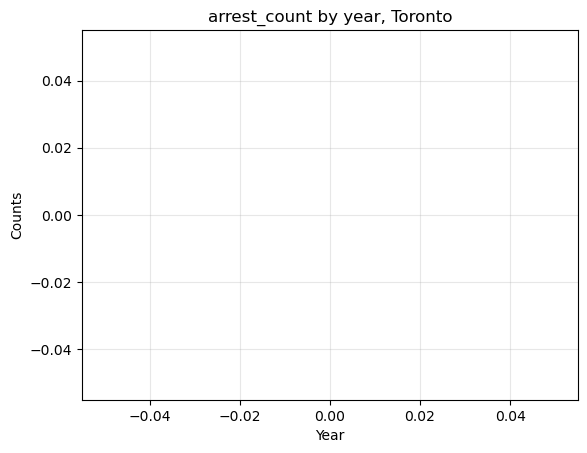

In [52]:
plotby_year_f(by_year,'arrest_count')

In [53]:
def conditions_f(row):    
    if row["age_group"] == 'Adult':
        row['_adult'] = row['arrest_count']
        row['_youth'] = 0
    elif row["age_group"] == 'Youth':
        row['_adult'] = 0
        row['_youth'] = row['arrest_count']
    return row[['_adult','_youth']]

In [54]:
def by_year_age_f(data: pd.DataFrame) -> pd.DataFrame:

    # Group rows by year
    year_age_group = data.groupby(['arrest_year','age_group'])

    # Add up all Total Arrests for each year
    year_age_sum = year_age_group.agg(arrest_count = ('arrest_count', 'sum')).reset_index()

    # dropping unknown age_group
    year_age_sum = year_age_sum.drop(year_age_sum[year_age_sum['age_group'] == 'Unknown'].index)  

    # create columns '_adult', '_youth' based on 'age_group
    year_age_sum[['_adult','_youth']] = year_age_sum.apply(conditions_f, axis=1)

    # drop 'age_group' and 'arrest_count' because these values have been moved to '_adult','_youth'
    year_age_sum = year_age_sum.drop(['age_group', 'arrest_count'], axis=1)

    # group by year 
    year_age_group = year_age_sum.groupby(['arrest_year']).agg(adult=('_adult','sum'),
                                       youth=('_youth','sum')).reset_index()

    return year_age_group

In [55]:
year_age_df = by_year_age_f(total_df)

ValueError: Columns must be same length as key

In [56]:
def plotby_year_age_f(data):
    barWidth = 0.35

    # Set the position of the bars on the x-axis
    r1 = np.arange(len(data['arrest_year']))
    r2 = [x + barWidth for x in r1]

    # Create the bar plots
    plt.bar(r1, data['adult'], color='#7f6d5f', width=barWidth, edgecolor='white', label='Adult')
    plt.bar(r2, data['youth'], color='#557f2d', width=barWidth, edgecolor='white', label='Youth')

    # Add x-axis and y-axis labels and a title
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.title('Arrest Counts by Year & Age group, Toronto')

    # Add legend
    plt.legend()

    #plt.show()

In [57]:
plotby_year_age_f(year_age_df)

NameError: name 'year_age_df' is not defined